# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, crystalline data, no beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured, and if necessary, the diffraction shifts corrected. 

The general elliptical distortion correction procedure can be found in ellipticaldistortion.ipynb.  This notebook is for the specific case of crystalline data in which a set of 4 equidistant diffraction spots is used for this calibration.  In this case, fitting an ellipse is insufficient to measure the elliptical distortion, as the result is degenerate.  Here, the additional constraint of a known angle between diffraction spots (from prior knowledge of the crystal structure) is used to remove the degeneracy, and thereby measure and correct the elliptical distorions.  For crystalline data with more than 4 equidistant diffraction peaks, the general procedure in ellipticaldistorion.ipynb should suffice.

We proceed as follows:

1. Fit an initial ellipse to the data
2. Find the degenerate ellipse which will yield the correct known angle between Bragg peaks 
3. Correct elliptical distortion
4. Measure final, corrected elliptical distortion

The relevant mathematics is found at the end of this notebook.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from matplotlib.patches import Circle, Ellipse

from py4DSTEM.file.io import FileBrowser
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion, constrain_degenerate_ellipse

In [2]:
# Examine file contents

fp = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5"
#fp = "/Users/Ben/Work/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_shiftcorrected       DiffractionSlice    
   1    braggvectormap_uncorrected          DiffractionSlice    
   2    probe                               DiffractionSlice    
   3    diffraction_shifts                  RealSlice           
   4    lattice_vectors                     PointList           
   5    braggpeaks                          PointListArray      
   6    braggpeaks_1                        PointListArray      
   7    braggpeaks_shiftcorrected           PointListArray      


In [4]:
# Load data

braggpeaks = browser.get_dataobject('braggpeaks')
braggvectormap = browser.get_dataobject('braggvectormap_shiftcorrected').data
browser.close()

R_Nx,R_Ny = braggpeaks.shape
Q_Nx,Q_Ny = 512,512

### Initial elliptical fit

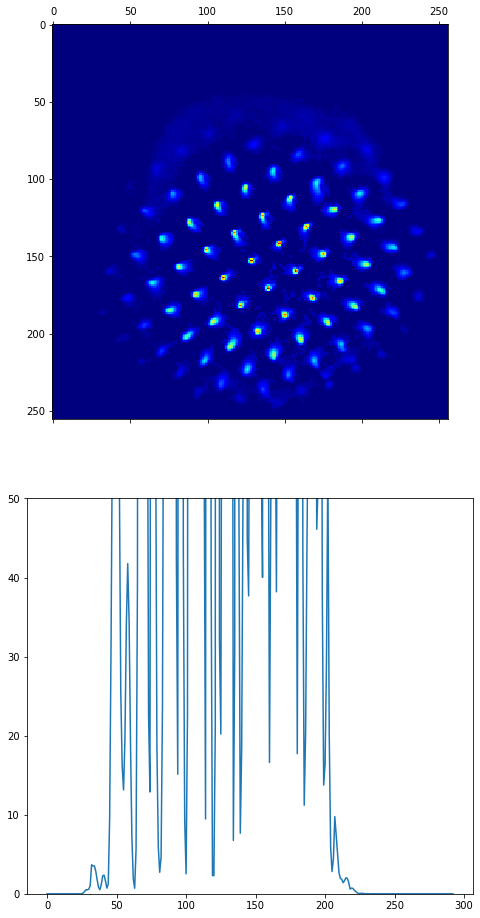

In [5]:
# Show Bragg vector map, calculate radial integral

ymax=50
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

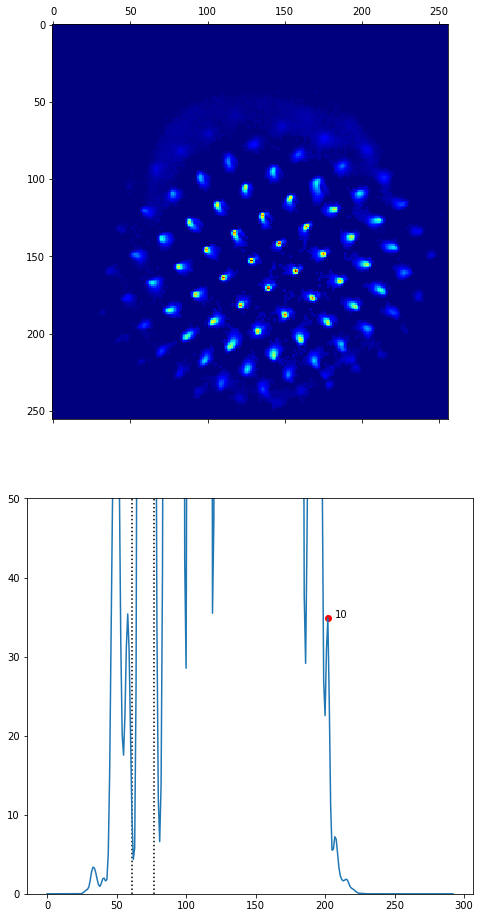

In [9]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 6
annulus_width = 16

# Display params
ymax=50
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

In [7]:
# Measure elliptical distortion

power=0.25

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Measure with a mask
# mask = np.ones_like(braggvectormap,dtype=bool)
# mask[:,int(y0-10):int(y0+10)] = False
# ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer, mask)
# x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

TypeError: Improper input: N=5 must not exceed M=0

### Contrain ellipse, using known angle

The above ellipse is one of the infinite family of ellipses fitting the four data points inside the annulus. Here we find the correct ellipse from this family.

In [8]:
# Set known angle
phi_known = 68  # in degrees

# Get contrained ellipse
phi_known = np.radians(phi_known)
a_constrained, b_constrained = constrain_degenerate_ellipse(braggvectormap,x,y,a,b,theta,r_inner,r_outer,phi_known)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ellipse = Ellipse((y,x),2*a_constrained,2*b_constrained,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a_constrained,b_constrained)/min(a_constrained,b_constrained) - 1)))

NameError: name 'x' is not defined

### Correct distortions

In [18]:
corrected_ellipse_params = [x,y,a_constrained,b_constrained,theta]
braggpeaks_corrected = correct_elliptical_distortion(braggpeaks, corrected_ellipse_params)

### Measure corrected elliptical distortions

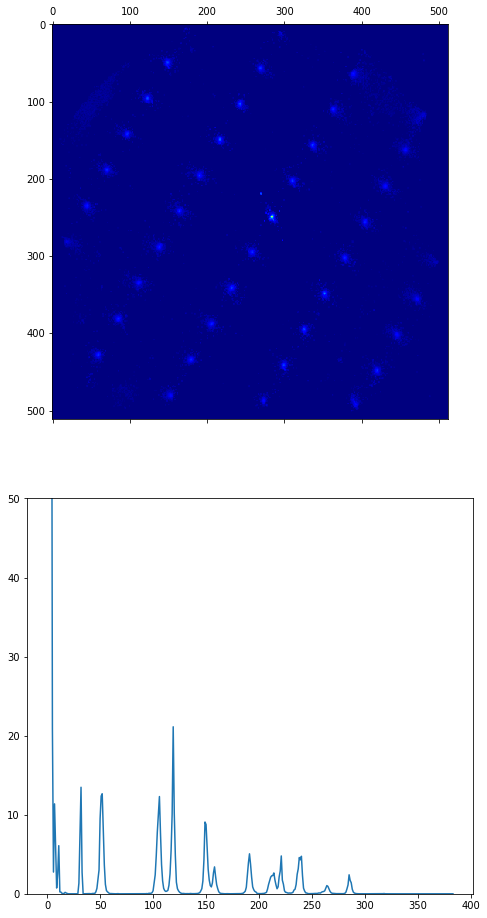

In [19]:
# Get new Bragg vector map and radial integral

ymax=50
power=0.25

braggvectormap_corrected = get_bragg_vector_map(braggpeaks_corrected,Q_Nx,Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_corrected,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(braggvectormap_corrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_corrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

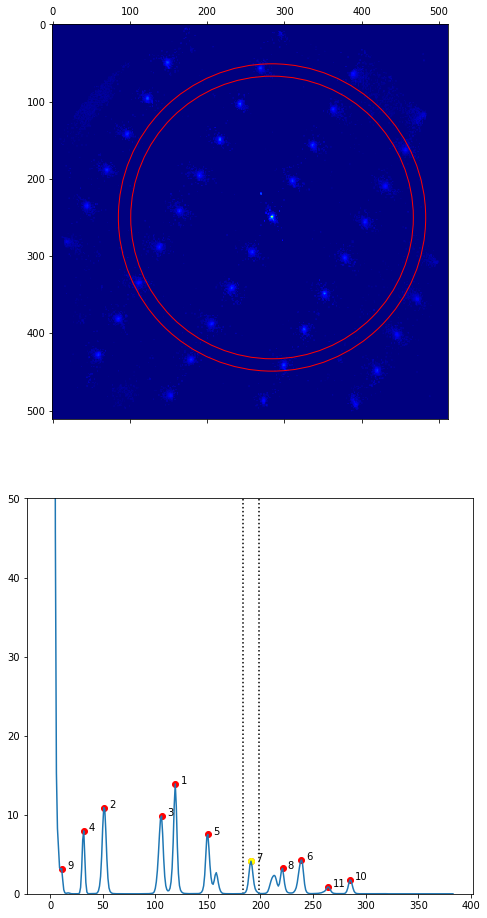

In [21]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 7
annulus_width = 16

# Display params
ymax=50
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_corrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

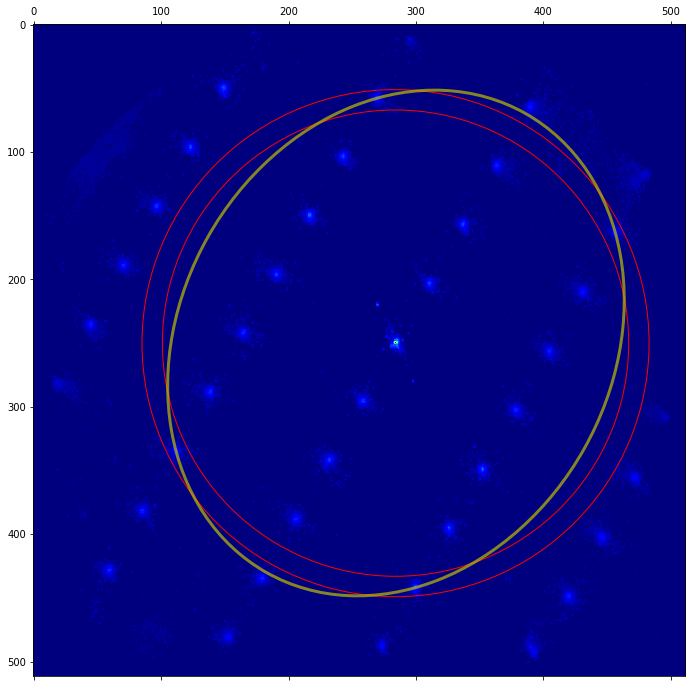

In [23]:
# Measure elliptical distortion

power=0.25

ellipse_params_corrected,_ = measure_elliptical_distortion(braggvectormap_corrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params_corrected

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_corrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

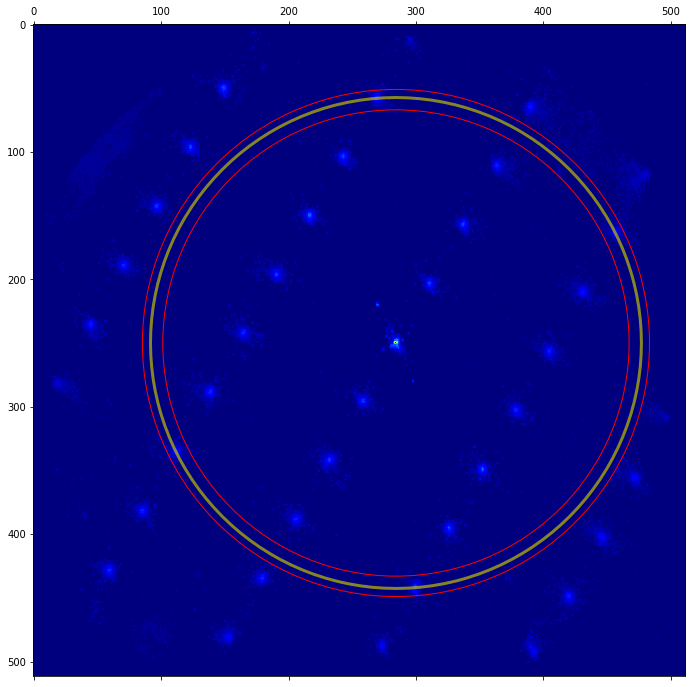

Measured elliptical distortion of 0.00656%


In [24]:
# Set known angle
phi_known = 68  # in degrees

# Get contrained ellipse
phi_known = np.radians(phi_known)
a_constrained, b_constrained = constrain_degenerate_ellipse(braggvectormap_corrected,x,y,a,b,theta,r_inner,r_outer,phi_known)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_corrected**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ellipse = Ellipse((y,x),2*a_constrained,2*b_constrained,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a_constrained,b_constrained)/min(a_constrained,b_constrained) - 1)))

### Relevant Mathematics

The math related to the elliptical fitting routines used in py4DSTEM is discussed in notebooks/modules/ellipticaldistortion.ipynb.  Here, we limit our discussion to the present case of constraining degenerate fits in the presence of four fit peaks.  The relevant family of ellipse all share their center and orientation angle; only the semiaxes vary.  See below.  Therefore, in these discussions, we take the origin at the ellipse center and  orient the coordinate axes along the ellipse axes.

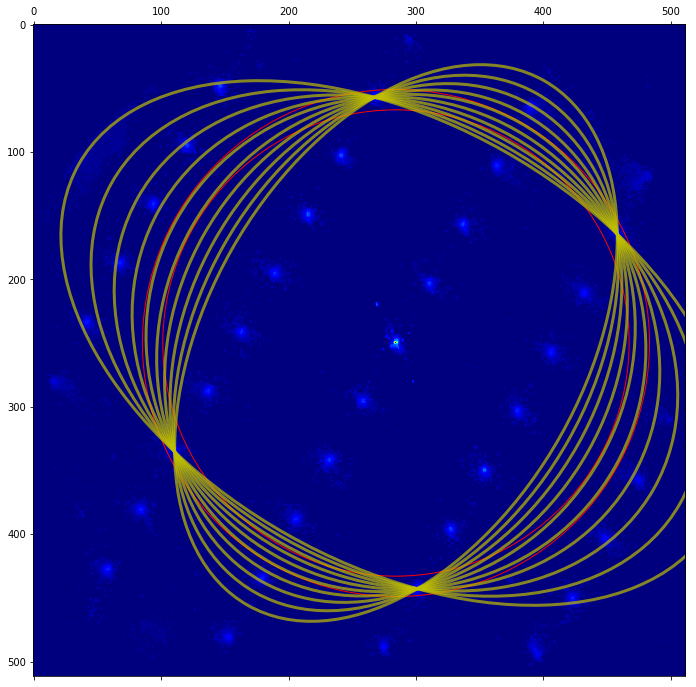

In [25]:
# Visualize degenerate family of ellipses fitting the data

phi_vals = np.radians(np.linspace(45,95,10))
a_vals,b_vals = np.zeros_like(phi_vals),np.zeros_like(phi_vals)
for i in range(len(phi_vals)):
    phi = phi_vals[i]
    a_vals[i],b_vals[i] = constrain_degenerate_ellipse(braggvectormap,x,y,a,b,theta,r_inner,r_outer,phi,fitrad=8)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
for i in range(len(phi_vals)):
    ellipse = Ellipse((y,x),2*a_vals[i],2*b_vals[i],90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
    ax.add_patch(ellipse)
plt.show()

Let the family of ellipses be given by

\begin{equation}
\frac{x^2}{a(t)^2} + \frac{y^2}{b(t)^2} = 1
\end{equation}

where the semiaxes $a(t)$ and $b(t)$ explicitly vary, and have been parametrized by some variable $t$.

Let us assume we have one ellipse in the relevant family from our fitting routing, therefore we have one pair of semiaxes $a_0$, $b_0$ fitting the data.  We additionally have four datapoints, which should be in each ellipse in the family.  Assume that one such point is given by $(x_0,y_0)$.  If we then take $a(t) = a_0t$, then we can solve for $b(t)$, and we find

\begin{align}
a(t) &= a_0t  \\
b(t) &= \left(\frac{y_0^2}{1-\frac{x_0^2}{a_0^2t^2}}\right)^{\frac{1}{2}}
\end{align}

Now we can also write our family of ellipses as

\begin{align}
x &= a(t)\cos\beta   \\
y &= b(t)\sin\beta
\end{align}

which is a useful form because after performing the affine transformation which converts the ellipse into a circle, the angle of point $(x,y)$ from the $x$-axis will be exactly $\beta$, because it will be true that $a(t) = b(t)$, so $\tan\frac{y}{x} = \tan\beta$.  If the angle of point $(x_0,y_0)$ is known by prior crystallographic consideration to be $\alpha$, then we need to select a value of $t$ such that the value of $\beta$ correspondiing to $(x_0,y_0)$ is exactly $\alpha$.  We therefore take the value of $t$ to be

\begin{equation}
t = \frac{x_0}{a_0}\sec\alpha
\end{equation}

Using this value of $t$ in the expressions above for $a(t)$ and $b(t)$ yields the ellipse of interest.

Finally, we note that the semiaxes of the ellipses for the geometry here will bisect the pairs of Bragg peaks. Thus $\alpha$ is half the angle between the known pair of peaks.  An ambiguity remains, in that the angle of interest is well specified only up to a complementary angle; here we take the convention that $\alpha$ should refer to the lesser of these two angles.